In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from typing import Union
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product
from tqdm import tqdm_notebook
from sklearn.metrics import r2_score


import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')


In [2]:
df_day = pd.read_csv("Daily Climate time series data/DailyDelhiClimateTrain.csv")
df_day_test = pd.read_csv("Daily Climate time series data\DailyDelhiClimateTest.csv")

In [3]:
df_day.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
data = pd.concat([df_day,df_day_test], axis=0)
print(data.shape)
data.drop_duplicates(subset='date',keep='first', inplace = True)
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')
data.set_index('date', inplace=True)
data = data.round(2)
# data = data.asfreq('d')

(1576, 5)


**Find outlier values by using boxplot**

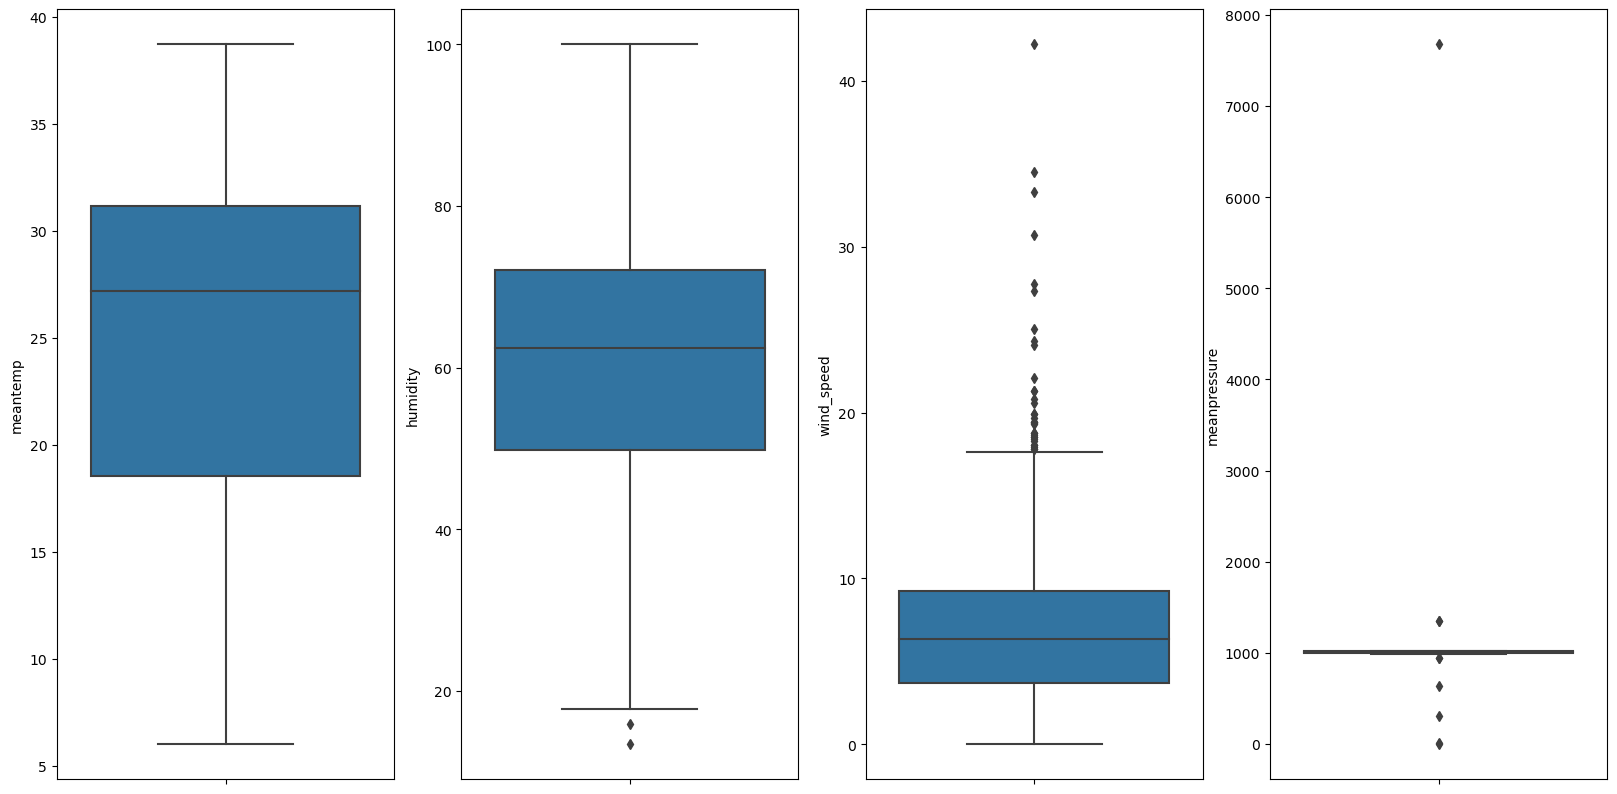

In [5]:
index = 1
fig = plt.figure(figsize=(20,10))
for col in data.columns:
    plt.subplot(1,4,index)
    sns.boxplot(y=data[col], data=data)
    index = index + 1


**QQ plot in order to verify the simmetry**

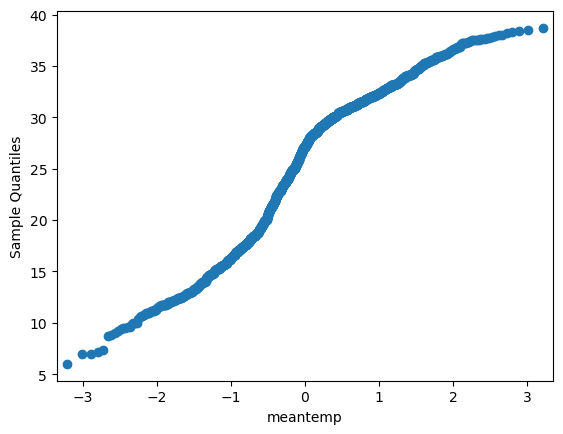

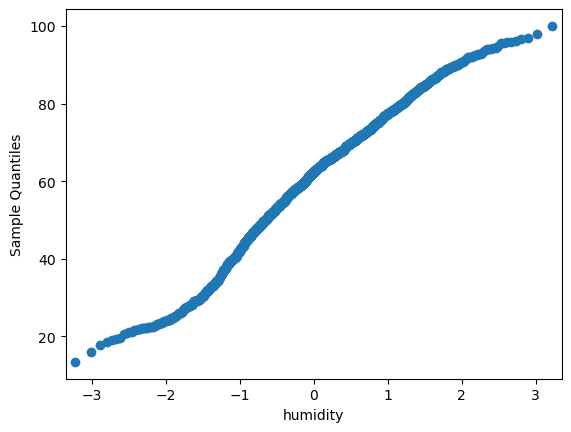

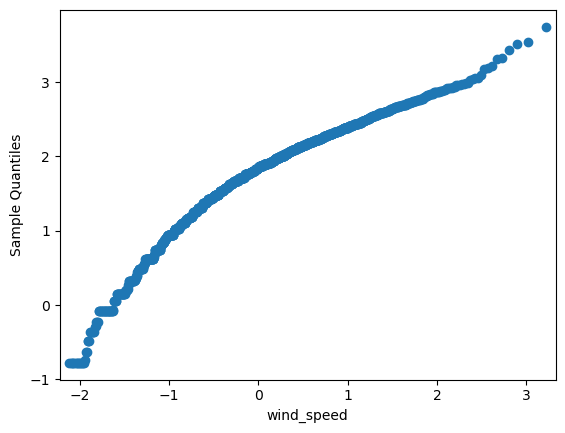

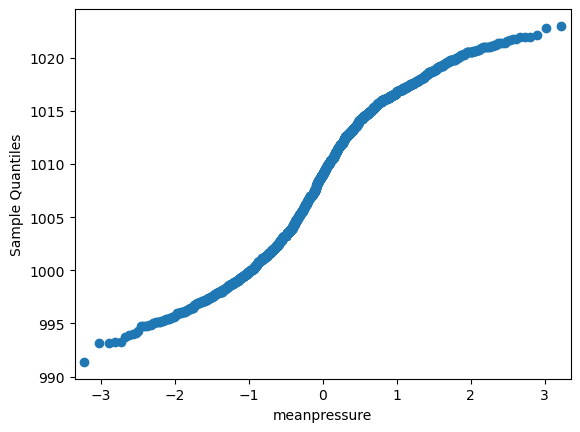

In [34]:
def qq_plot(data: pd.DataFrame):
    
    sm.qqplot(data.iloc[:,0])
    plt.xlabel(f"{data.columns[0]}")

    sm.qqplot(data.iloc[:,1])
    plt.xlabel(f"{data.columns[1]}")
    
    sm.qqplot(np.log(data.wind_speed))
    plt.xlabel(f"{data.columns[2]}")

    sm.qqplot(data.iloc[:,3])
    plt.xlabel(f"{data.columns[3]}")

qq_plot(data)


**Behavior of the variables per month**

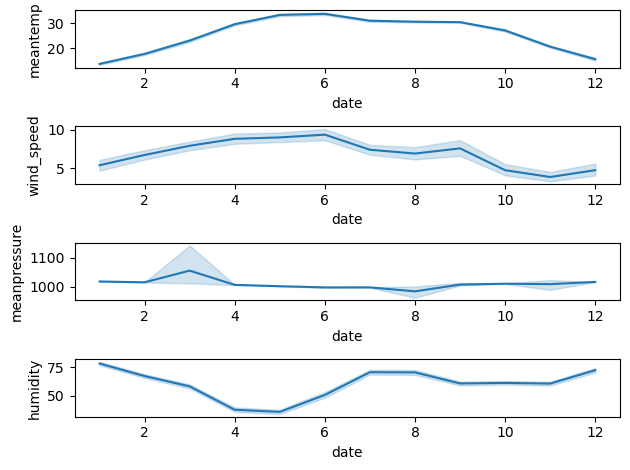

In [7]:
fig,axis = plt.subplots(4,1)
sns.lineplot(x = data.index.month,y = data.meantemp,data=data, ax=axis[0]);
sns.lineplot(x = data.index.month,y = data.wind_speed,data=data, ax = axis[1]);
sns.lineplot(x = data.index.month,y = data.meanpressure,data=data, ax = axis[2]);
sns.lineplot(x = data.index.month,y = data.humidity,data=data, ax = axis[3]);
plt.tight_layout()

**Preprocesing**


In [8]:
mask = (data['meanpressure'] >1200) | (data['meanpressure'] < 980)
data['meanpressure'] = np.where(mask,np.nan,data['meanpressure'])
data['meanpressure'] = data['meanpressure'].interpolate()
data['win_speed_log'] = np.log(data.wind_speed)

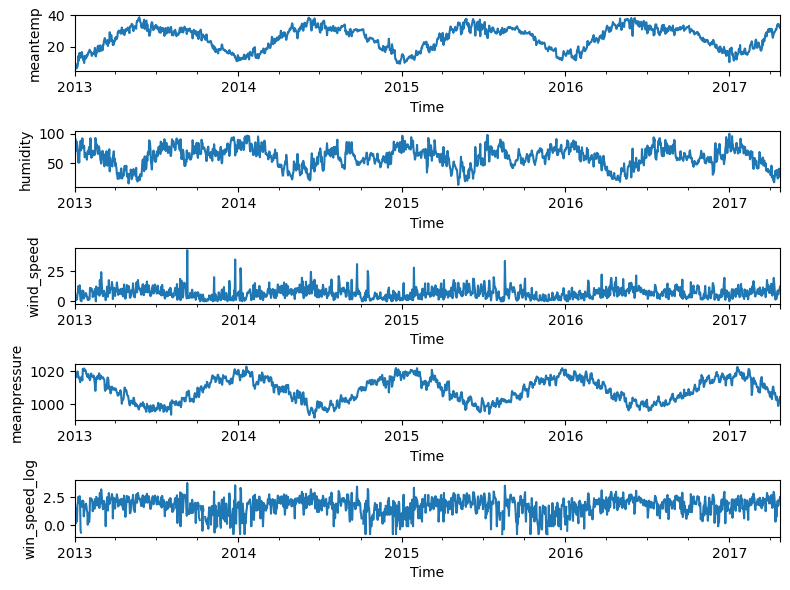

In [9]:
def plot_ts(data):
    columns = data.columns 
    fig,axis = plt.subplots(5,1, figsize = (8,6))
    index = 0
    for col in columns:
        data[col].plot(ax=axis[index])
        axis[index].set(xlabel='Time', ylabel=str(col))
        index = index + 1
        
    fig.tight_layout()
    plt.show()

plot_ts(data)

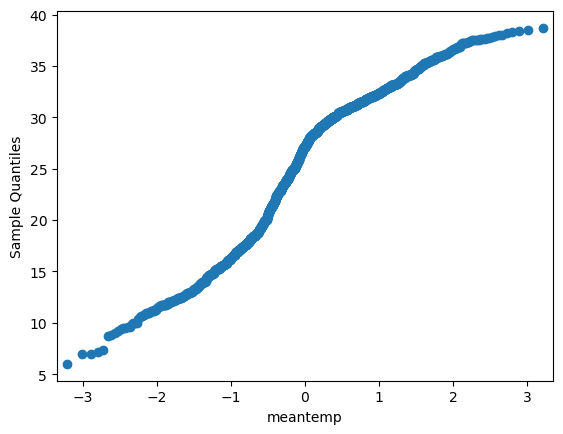

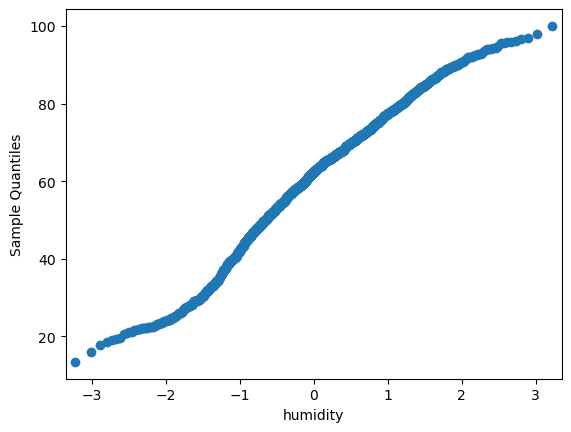

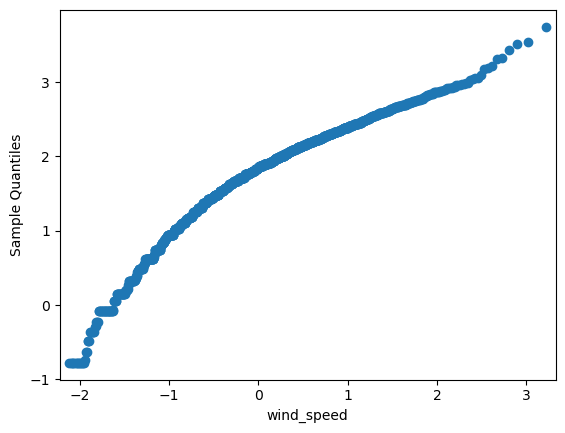

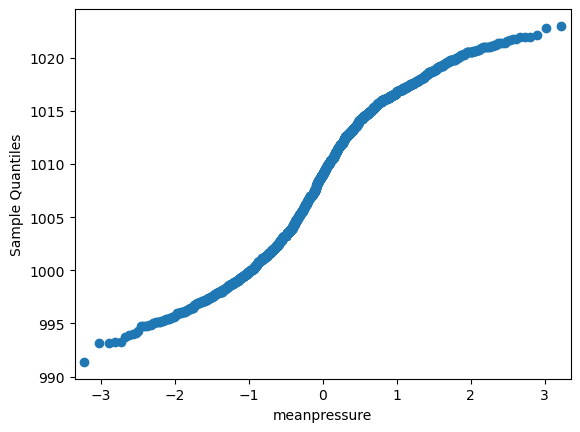

In [10]:
qq_plot(data)

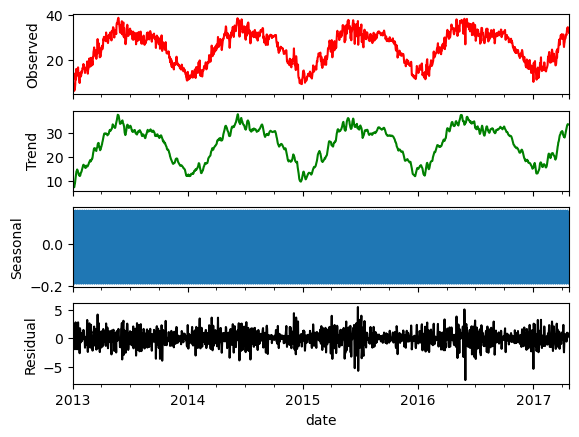

The p-value of meanpressure:  0.14809841131112622
It's no stationary

Autocorrelacion


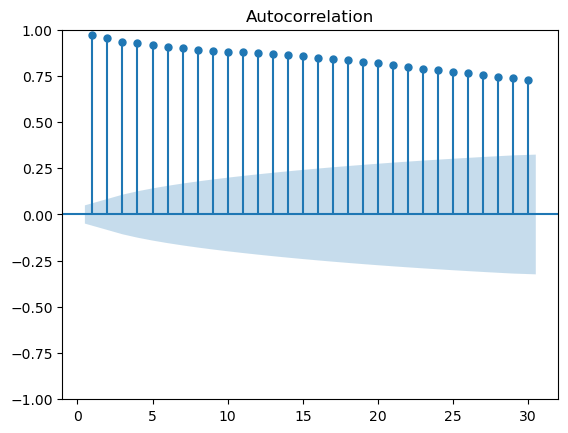

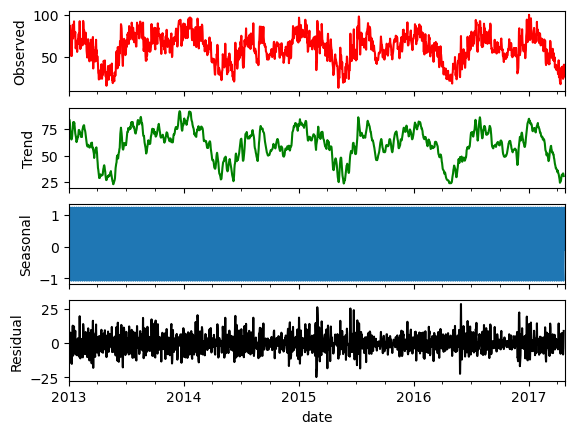

The p-value of meanpressure:  0.005138829498111199
It's stationary

Autocorrelacion


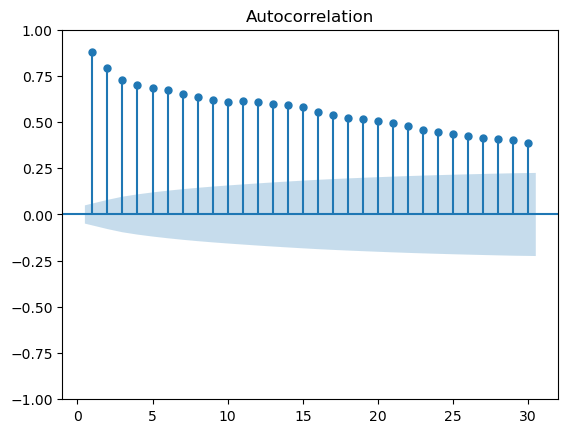

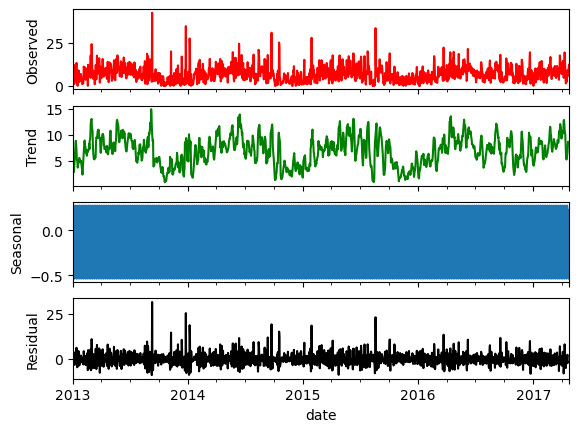

The p-value of meanpressure:  0.0013833466476952955
It's stationary

Autocorrelacion


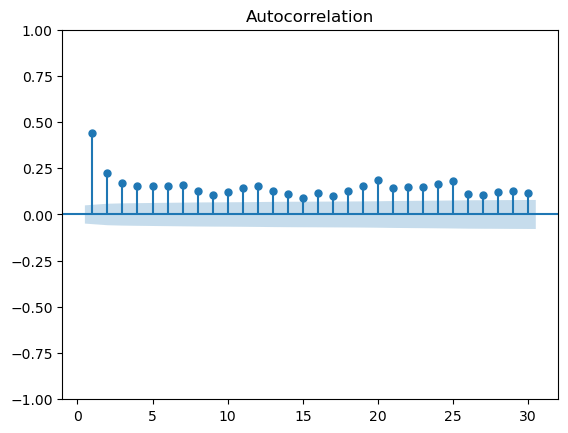

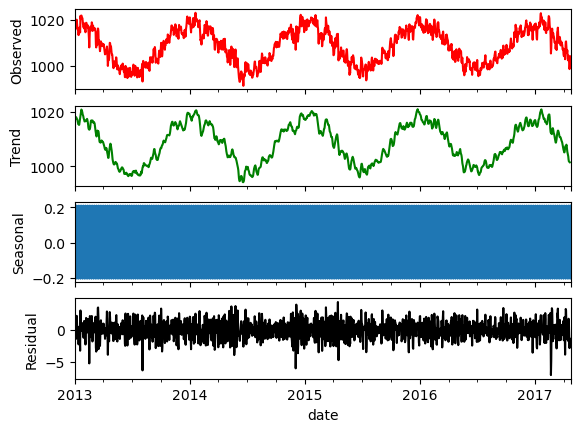

The p-value of meanpressure:  0.15961338530942176
It's no stationary

Autocorrelacion


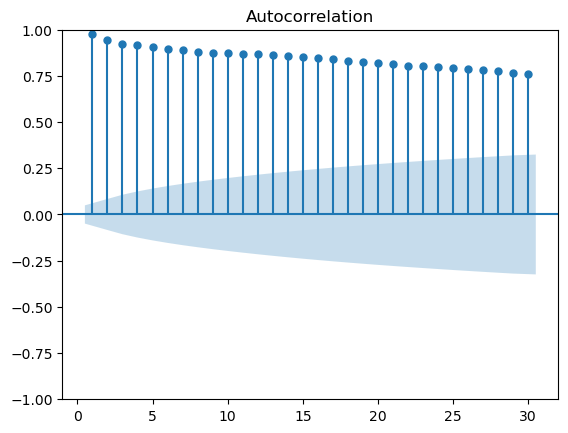

In [11]:
def all_data_results(data: pd.DataFrame):   
    s_dec_additional = seasonal_decompose(data, model="additive")
    fig, axes = plt.subplots(4, 1, sharex = True)
    s_dec_additional.observed.plot(ax=axes[0], legend=False, color='r')
    axes[0].set_ylabel('Observed')
    s_dec_additional.trend.plot(ax=axes[1], legend=False, color='g')
    axes[1].set_ylabel('Trend')
    s_dec_additional.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    s_dec_additional.resid.plot(ax=axes[3], legend=False, color='k')
    axes[3].set_ylabel('Residual')
    plt.show()

    print(f"The p-value of meanpressure:  {adfuller(data)[1]}")
    print("It's stationary") if (adfuller(data)[1] < 0.05 and adfuller(data)[0]<adfuller(data)[4]['5%']) else print("It's no stationary")
    print(f"\nAutocorrelacion")
    plot_acf(data, zero=False, lags=30);

    
for col in data.columns[:4]:
    all_data_results(data[col])

**Exponential model**

The meantemp


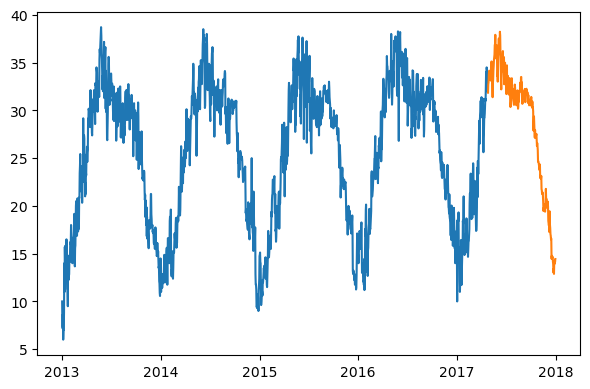



The humidity


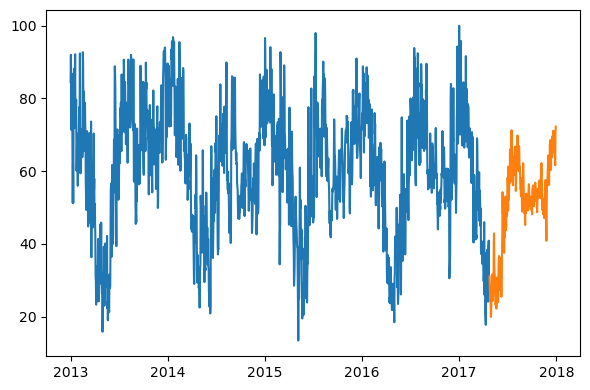



The wind_speed


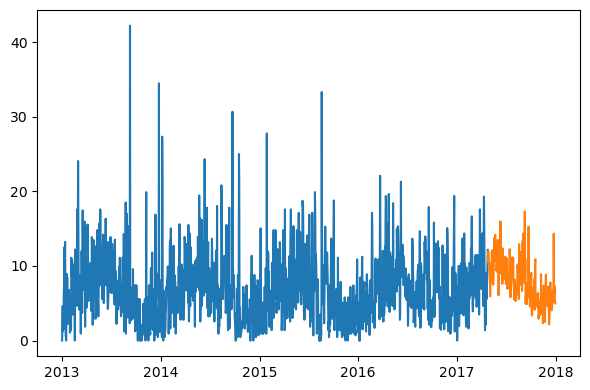



The meanpressure


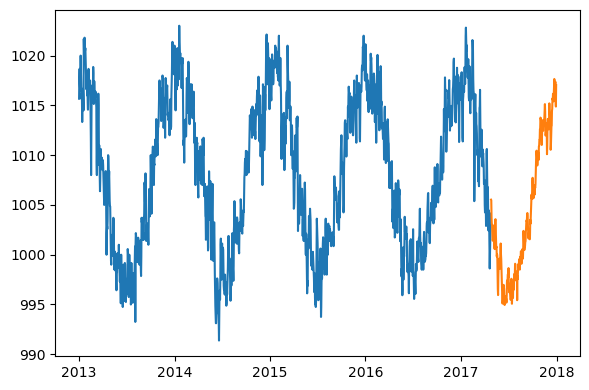

In [12]:
def Exponential_Model(df: Union[pd.DataFrame, list]):
       
    model_add = ExponentialSmoothing(df, seasonal = 'add', seasonal_periods=365).fit()
    
    fig, ax = plt.subplots(figsize = (6,4))
    ax.plot(df)
    ax.plot(model_add.forecast(250))
    plt.tight_layout()
    plt.show()


for col in data.columns[:4]:
    print(f'The {col}')
    Exponential_Model(data[col])
    print('\n')



In [13]:
def create_features(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['dayofyear'] = df.index.day_of_year
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df



Verify the stationarity

In [14]:
meanpressure = data.meanpressure
wind_speed = data.wind_speed
meantemp = data.meantemp
humidity = data.humidity


It's not stationary

Differencing...
The number of difference to assure the stationarity is: 1


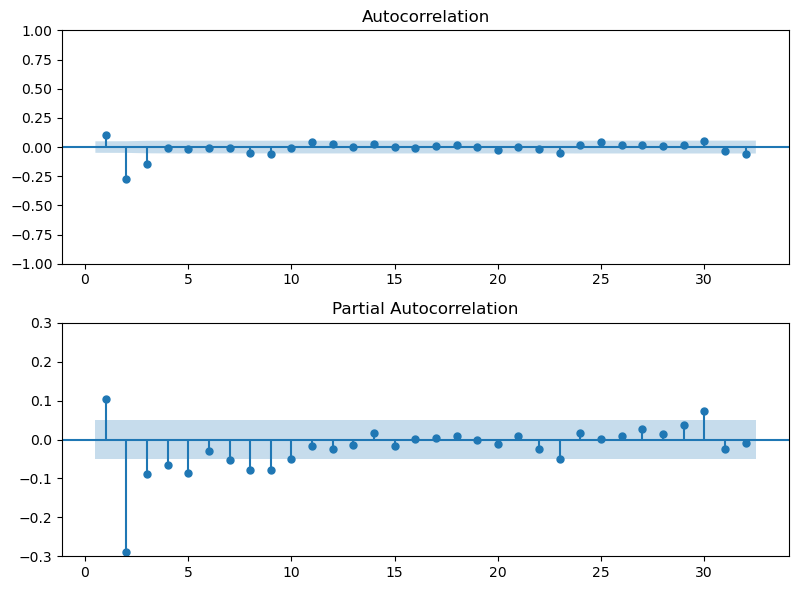

In [15]:
def meanpressure_func(df):
    
    if adfuller(df)[1] < 0.05:
        print("The original serie is not stationary")
        (df
            .plot
            .line()
        )
        plt.show()
        fig, axis = plt.subplots(2,1, figsize = (8,6))
        plot_acf(df, zero=False, ax=axis[0])
        plt.ylim([-0.3,0.3])
        plot_pacf(df, zero=False, ax=axis[1])
        plt.ylim([-0.3,0.3])
        plt.tight_layout()
    else:
        d = 0
        print("It's not stationary")
        print('\nDifferencing...')
        while adfuller(df)[1] > 0.05 and adfuller(df)[4]['5%'] < adfuller(df)[0]:
            d+=1
            df = (df.
                    diff()
                    .dropna()
                )
        print(f'The number of difference to assure the stationarity is: {d}')


        fig, axis = plt.subplots(2,1, figsize = (8,6))
        plot_acf(df, zero=False, ax=axis[0])
        plt.ylim([-0.3,0.3])
        plot_pacf(df, zero=False, ax=axis[1], method='ols')
        plt.ylim([-0.3,0.3])
        plt.tight_layout()
        plt.show()
        # test.plot(legend=True,figsize=(12,6))
        # plt.plot(test.index, predictions)
        # ax.autoscale(axis='x',tight=True)
       

        
        
meanpressure_func(meanpressure)  

Implementing SARIMA because the seasonal component is considered and there is no stationery in each feature.

**SARIMA_Optimization**

In this case, we find out the best structure of SARIMA model based on Akaike Information Criterion (AIC) estimator 

In [16]:
def sarima_optimizated(endog:pd.DataFrame, seasonal:int)->pd.DataFrame:
    
    p,q = range(0,5,1),range(0,5,1)
    P,Q = range(0,5,1),range(0,5,1)
    D = 0
    d = 1
    
    orders = list( product(p,q,P,Q))
    sarima_result = []
    
    for order in tqdm_notebook(orders):

        model =  SARIMAX(endog = endog, 
                        order = (order[0],d,order[1]),
                        seasonal_order = (order[2],D,order[3],seasonal),
                        simple_differencing=False).fit(disp = False)
        aic = model.aic
        sarima_result.append([order, aic])
    
    df_result = pd.DataFrame(sarima_result, columns=['p,q,P,Q', 'AIC'])
    df_result = df_result.sort_values(by='AIC').reset_index(drop=True)

    return df_result  



In [17]:
def rolling_estimate(endog: pd.DataFrame, len_train: int, window:int, order:tuple, D:int, d:int, s:int )->list:
    pred_SARIMA = []
    for i in tqdm_notebook( range(len(endog[:len_train]), len(endog), window)):
        model = SARIMAX(endog=endog[:i], 
                        order= (order[0],d,order[1]), 
                        seasonal_order=(order[2],D,order[3],s), 
                        simple_differencing=False).fit(disp=False)
        prediction = model.get_prediction(0, i + window - 1)
        pred_SARIMA.extend( prediction.predicted_mean[-window:]  )

    return pred_SARIMA

In [18]:
LIMIT = 100
train = data[:-LIMIT]
test = data[-LIMIT:]
s = 7
D = 0
d = 1
LEN_TRAIN = len(data) - LIMIT
WINDOW = 2

**Meanpressure**

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

R2 metric: 0.8419538011297139


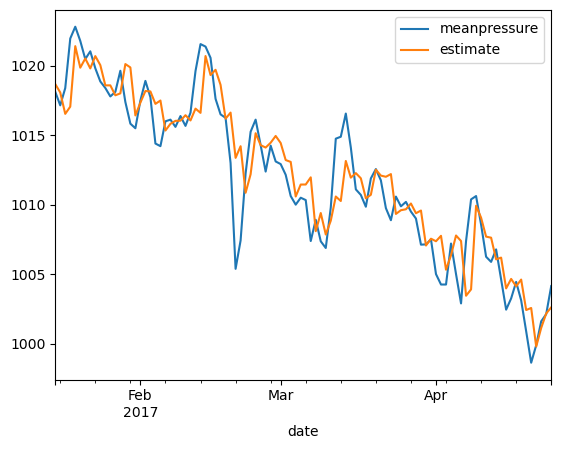

In [19]:
meanpressure = pd.DataFrame(meanpressure)
df_meanpressure_opt = sarima_optimizated(train.meanpressure, s)
ORDER = df_meanpressure_opt.iloc[0,0]
prediction_sarima = rolling_estimate(meanpressure, LEN_TRAIN, WINDOW, ORDER, D, d,s)

train_meanpressure = meanpressure[:-LIMIT]
test__meanpressure = meanpressure[-LIMIT:]
test__meanpressure['estimate'] = prediction_sarima
print(f"R2 metric: {r2_score(test__meanpressure['meanpressure'], test__meanpressure['estimate'])}")
test__meanpressure.plot()
plt.show()


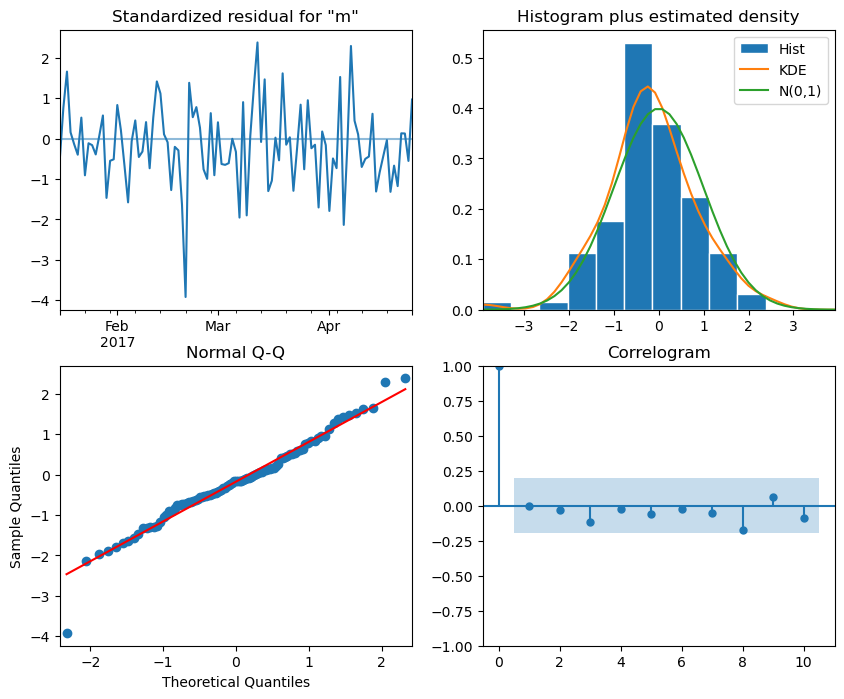

In [58]:
p = df_meanpressure_opt.iloc[0,0][0]
q = df_meanpressure_opt.iloc[0,0][1]
P = df_meanpressure_opt.iloc[0,0][2]
Q = df_meanpressure_opt.iloc[0,0][3]
d = 1
model = SARIMAX(test__meanpressure.iloc[:,0], order=(1,1,2), seasonal_order=(P, D, Q, s), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10, 8));



**Wind speed**

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

R2 metric: 0.08503726204998252


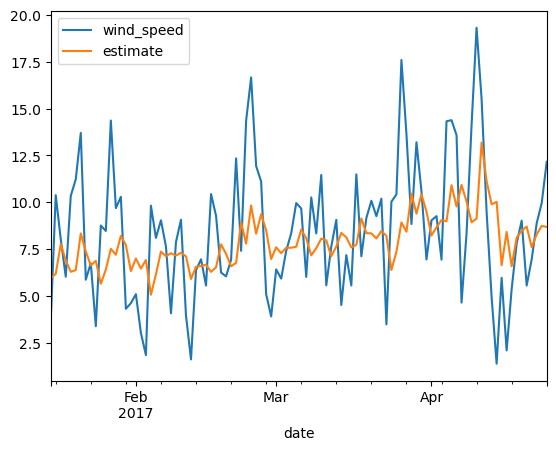

In [20]:
wind_speed = pd.DataFrame(wind_speed)
df_wind_speed_opt = sarima_optimizated(train.wind_speed, s)
ORDER = df_wind_speed_opt.iloc[0,0]
prediction_sarima = rolling_estimate(wind_speed, LEN_TRAIN, WINDOW, ORDER, D, d,s)

train_wind_speed = wind_speed[:-LIMIT]
test_wind_speed = wind_speed[-LIMIT:]
test_wind_speed['estimate'] = prediction_sarima
print(f"R2 metric: {r2_score(test_wind_speed['wind_speed'], test_wind_speed['estimate'])}")
test_wind_speed.plot()
plt.show()

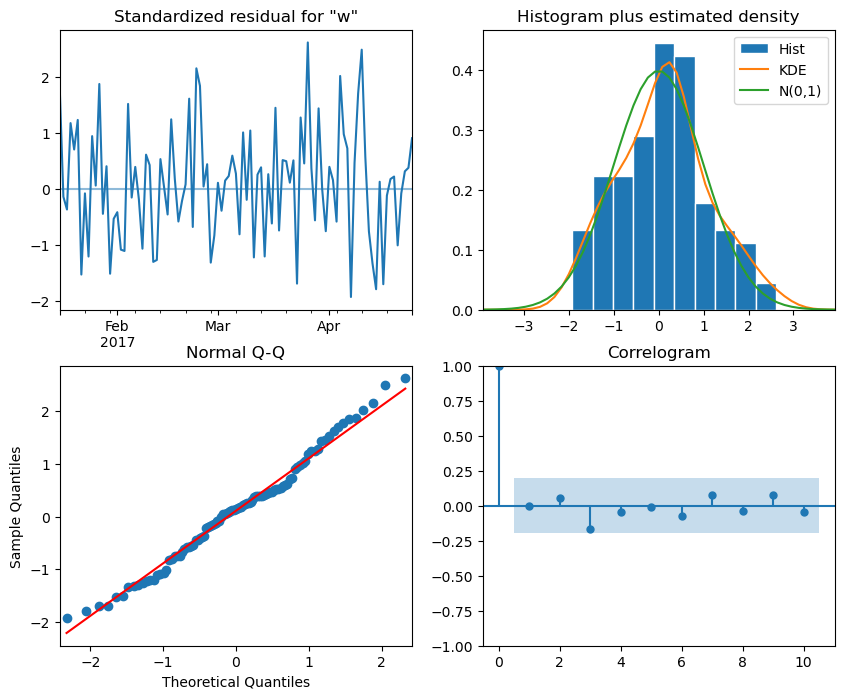

In [56]:
p = df_wind_speed_opt.iloc[0,0][0]
q = df_wind_speed_opt.iloc[0,0][1]
P = df_wind_speed_opt.iloc[0,0][2]
Q = df_wind_speed_opt.iloc[0,0][3]
d = 1
model = SARIMAX(test_wind_speed['wind_speed'], order=(1,1,2), seasonal_order=(P, D, Q, s), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10, 8));

**humidity**

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

R2 metric: 1.0


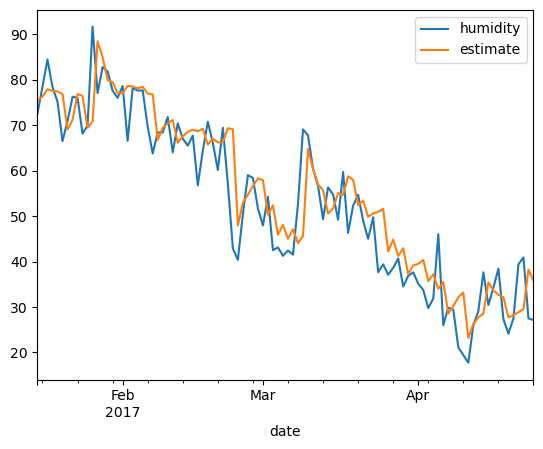

In [21]:
humidity = pd.DataFrame(humidity)
df_humidity_opt = sarima_optimizated(train.humidity, s)
ORDER = df_humidity_opt.iloc[0,0]
prediction_sarima = rolling_estimate(humidity, LEN_TRAIN, WINDOW, ORDER, D, d,s)

train_humidity = humidity[:-LIMIT]
test_humidity = humidity[-LIMIT:]
test_humidity['estimate'] = prediction_sarima
print(f"R2 metric: {r2_score(test_humidity['humidity'], test_humidity['humidity'])}")
test_humidity.plot()
plt.show()

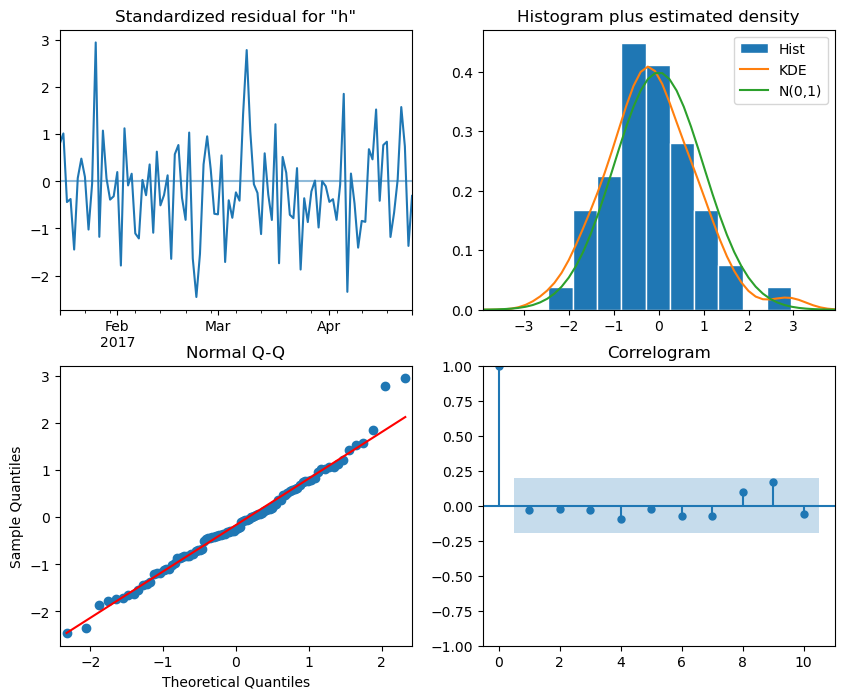

In [59]:
p = df_humidity_opt.iloc[0,0][0]
q = df_humidity_opt.iloc[0,0][1]
P = df_humidity_opt.iloc[0,0][2]
Q = df_humidity_opt.iloc[0,0][3]
d = 1
model = SARIMAX(test_humidity.iloc[:,0], order=(1,1,2), seasonal_order=(P, D, Q, s), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10, 8));

**meantemp**

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

R2 metric: 0.8932648574243267


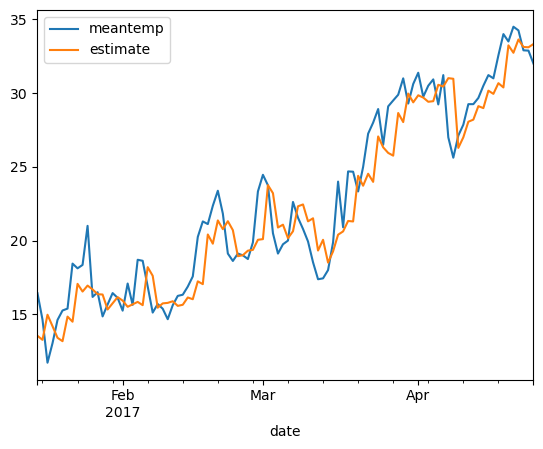

In [22]:
meantemp = pd.DataFrame(meantemp)
df_meantemp_opt = sarima_optimizated(train.meantemp, s)
ORDER = df_meantemp_opt.iloc[0,0]
prediction_sarima = rolling_estimate(meantemp, LEN_TRAIN, WINDOW, ORDER, D, d,s)

train_meantemp = meantemp[:-LIMIT]
test_meantemp = meantemp[-LIMIT:]
test_meantemp['estimate'] = prediction_sarima
print(f"R2 metric: {r2_score(test_meantemp['meantemp'], test_meantemp['estimate'])}")
test_meantemp.plot()
plt.show()

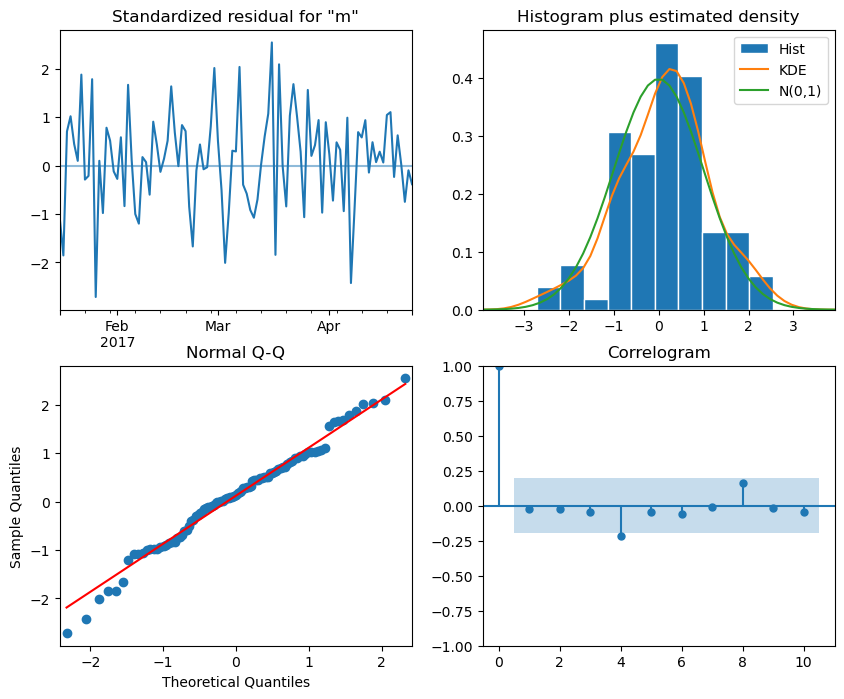

In [60]:
p = df_meantemp_opt.iloc[0,0][0]
q = df_meantemp_opt.iloc[0,0][1]
P = df_meantemp_opt.iloc[0,0][2]
Q = df_meantemp_opt.iloc[0,0][3]
d = 1
model = SARIMAX(test_meantemp.iloc[:,0], order=(1,1,2), seasonal_order=(P, D, Q, s), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10, 8));